<a href="https://colab.research.google.com/github/DrugowitschLab/ML-from-scratch-seminar/blob/master/DeepRL/DeepRL-solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning

In this session, we will use Open AI Gym to implement Q-learning, a classic algorthim in RL, and Deep Q-Networks (DQN), its deep learning counterpart. Hopefully this will give us some intuition for what we gain by moving from tabular methods to using neural networks for function approximation.

## Setup



First, let's install the necessary dependencies. This does not need to be run again if you restart the runtime, but it does if you factory reset the runtime. 

In [2]:
!sudo apt-get install -y xvfb ffmpeg
!apt-get install x11-utils
!pip install 'gym==0.17.1'
!pip install 'pyglet==1.4.0'
!pip install pyvirtualdisplay
!pip install --upgrade tensorflow-probability
!pip install imageio-ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 784 kB in 2s (355 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselecte

Now let's import the packages we will be using.

In [0]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import random
import tensorflow as tf
import gym

from gym.spaces import Discrete
from gym.spaces import Box
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from collections import deque
from pyvirtualdisplay import Display

In [4]:
print(tf.version.VERSION)
print(gym.version.VERSION)

2.2.0-rc3
0.17.1


## Introduction to Open AI Gym

Gym provides you with a set of [environments](https://gym.openai.com/envs/#classic_control). If we think of the classic RL framework schematic, Gym takes care of the environment, and you take care of the agent. 

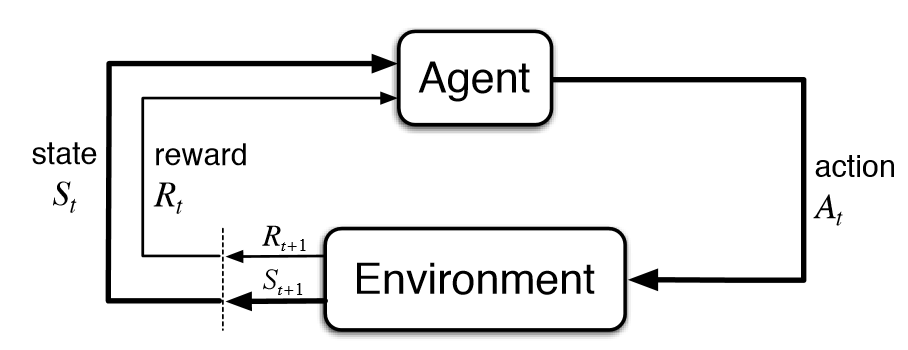

From this diagram, we can expect that we will interact with a Gym environment by giving it an action as input, and receiving a next state and reward as output. 

It is then our job to implement some algorithm to learn the policy $\pi(a|s)$ for our agent to use to act within the environment. 

### Setting up visualization

First, let's get plotting for Gym working in Colab. This will help give us an intuitive feel for how to work with the Gym environments.

In [0]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

Before we get to implementing algorithms for our agents to learn a good policy, let's visualize an agent acting according to a random policy. At this point the visualizatation is just to give us an idea of what what an environment looks like, and later on we'll come back to see how we generate this video. 

In [0]:
def create_random_policy_video(env, filename, num_episodes=5, fps=30):
    """Generates a visualization of an agent acting according to a random
    policy in the given environment."""
    display = Display(visible=0, size=(400, 300))
    display.start()
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            done = False
            observation = env.reset()
            video.append_data(env.render(mode='rgb_array'))
            while not done:
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
                video.append_data(env.render(mode='rgb_array'))
    display.stop()
    return embed_mp4(filename)

In [7]:
env = gym.make("MsPacman-v0")
create_random_policy_video(env, "video", num_episodes=1)

This is pretty cool! In this example Gym gives us a great visualization of our agent playing PacMan (though not very well). 

### Gym basics

#### Environments

As we would expect, an environment is defined by its state and action spaces.

First, of all there are two types of Gym [spaces](https://gym.openai.com/docs/#spaces):
- **`observation_space`**: defines the state space of the environment
- **`action_space`**: defines the action space of the environment

Spaces can be: 
- `gym.spaces.Discrete`: fixed range of n values 
- `gym.spaces.Box`: n-dimensional box

You can inspect the valid range for a `Box` by calling `Box.low()` and `Box.high()`.



In [0]:
env = gym.make("MsPacman-v0")
print(f'Action space: {env.action_space}')
print(f'Observation space: {env.observation_space}')

Action space: Discrete(9)
Observation space: Box(210, 160, 3)


We can see here that for `MsPacman-v0`, the `action_space` consits 9 possible actions, and the `observation_space` is a 210 x 160 x 3 box (rgb-image). We can also extract these dimensions using `Discrete.n` and `Box.shape`. 



In [0]:
print(env.action_space.n)
print(env.observation_space.shape)

9
(210, 160, 3)


If we're curious, we can find the action meanings by calling,

In [0]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


I would've guessed that the `action_space` would be just up, down, left, right, but apparently this implementation includes combination actions as well. Theoretically you don't "need" to know these details about the environment you're using because your algorithm should learn a good policy given whatever the available action space is, but I think it's still nice to get a sense of.

#### Key functions for interacting with the environment


We will mainly use three functions for interacting with the environment.

**`observation = env.reset()`**

- This function returns the starting state of an environment. We will call this function any time we want to start a new episode. 


**`observation, reward, done, info = env.step(action)`**

- This function is how your agent takes actions in the environment; it defines the transition and reward function. It takes in an `action` as an argument, and returns the next `observation`(next_state), the `reward` (**float**), if the episode is `Done` (**bool**), and `info`, which we won't be using here but can contain helpful information for debugging. 

**`action = env.action_space.sample()`**
- This is a helpful function for sampling a random action from the `action_space`. We will be using the $\epsilon$-greedy exploration strategy, so we will use this function when we want to select a random action.


If we look back at the code for `create_random_policy_video()`, we can see how we used these three functions to get the data for the video. Stripping away all code for plotting, the main loop is:

In [0]:
num_episodes = 1
env = gym.make("MsPacman-v0")

for _ in range(num_episodes):
    observation = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)

In this notebook, we will generally replace the term `observation` with `state` becuase this is the wording we're more familiar with.

## Implementing RL algorithms

Now that we have all of the setup done, let's get to the fun part of actually implementing the algorithms!

### CartPole environment

For our implementations we are going to use the `CartPole-v1` environment. This is a simple environment where both of our algorithms (Q-learning and DQN) will be able to learn a good policy within a reasonably short amount of time. 



In [0]:
env = gym.make("CartPole-v1")

The goal in this environment is to move the cart left or right in order to balance the pole so that it remains upright. 

In [9]:
create_random_policy_video(env, "video", num_episodes= 10)

In [0]:
print(f'Action space: {env.action_space}')
print(f'State space: {env.observation_space}')

Action space: Discrete(2)
State space: Box(4,)


This is a dramatically simpler environment than the MsPacman environment. The `observation_space` is a 4 dimensional array, and there are 2 possible actions. The CartPole [documentation](https://github.com/openai/gym/wiki/CartPole-v0) tells us the meanings of the observation and action spaces.

    Observation: 
        Type: Box(4)
        Num	Observation               Min             Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                -24 deg         24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right

An episode terminates when the pole falls more than 12 degrees from vertical, the cart position moves off-screen, or the number of steps within the episode exceeds 500.

### Required functions for learning a policy

In [0]:
class Agent:

    def create_model(self):
        """This model will be used by the act() method to select actions, 
        and will be updated during training """
        pass

    def act(self, test=False):
        """This function implements your policy and choose actions based on the 
        current model. If test=True, actions chosen without exploration."""
        pass

    def update_model(self):
        """This function specifies how to update the model based on experience 
        in the environment"""
        pass

    def train(self):
        """The main loop for training the model by selecting actions,  
        interacting with the environment, and updating the model"""
        pass

Once we have a trained model, we can evaluate it's performance using a similar loop to the one above used to visualize the random policy. The only difference is that we replace the `env.action_space.sample()` function call with `agent.act()`.

    agent = Agent()
    agent = Agent.train()
    
    # run trained agent
    for _ in range(num_episodes):
        state = agent.env.reset()
        done = False
        while not done:
            action = agent.env.act(state, test=True)
            next_state, reward, done, info = env.step(action)

### Evaluation functions

Now we can use this loop to generate a video  visualizing the learned policy.

In [0]:
def create_learned_policy_video(agent, filename, num_episodes=5, fps=30):
    """Generates a video of the given agent acting accoring to its learned 
    policy for the specified number of episodes."""
    display = Display(visible=0, size=(400, 300))
    display.start()
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            done = False
            state = agent.env.reset()
            video.append_data(agent.env.render(mode='rgb_array'))
            while not done:
                action = agent.act(state, test=True)
                state, reward, done, info = agent.env.step(action)
                video.append_data(agent.env.render(mode='rgb_array'))
    display.stop()
    return embed_mp4(filename)

We will also want to evaluate the performance of the learned model. For evaluation trials we will not use $\epsilon$-greedy exploration, but instead always choose the best action according to our learned policy.

In [0]:
def evaluate_policy(agent, num_episodes=10):
    """Runs the agent through the specified number of episodes and prints the 
    average return. """
    reward_history = []
    for _ in range(num_episodes):
        state = agent.env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state, test=True)
            next_state, reward, done, _ = agent.env.step(action)
            total_reward += reward
            state = next_state
        reward_history.append(total_reward)    

    print("Exploit reward average: {}".format(np.mean(reward_history).round(2)))

## Q-Learning



Tabular Q-learning stores and updates a Q-value estimate for each state-action pair, $Q(s,a)$. Each of these Q-values is stored in a look-up table.

**Discretize environment observations**

Since the cartpole environment has an `observation_space` with continuous values, the number of Q-values we need to store and update would quickly explode, and also not be very useful. To avoid this we are going to use a wrapper for the environment that transforms the `obervation_space` from a continuous-valued `Box` to a discrete-valued `Discrete`. I got this wrapper from Lillian Weng's Q-learning [implementation](https://github.com/lilianweng/deep-reinforcement-learning-gym/blob/master/playground/utils/wrappers.py) (understanding the details of how she implements this isn't important for what we're focusing on).

In [0]:
class DiscretizedObservationWrapper(gym.ObservationWrapper):
    """This wrapper converts a Box observation into a single integer.
    """
    def __init__(self, env, n_bins=10, low=None, high=None):
        super().__init__(env)
        assert isinstance(env.observation_space, Box)

        low = self.observation_space.low if low is None else low
        high = self.observation_space.high if high is None else high

        self.n_bins = n_bins
        self.val_bins = [np.linspace(l, h, n_bins + 1) for l, h in
                         zip(low.flatten(), high.flatten())]
        self.observation_space = Discrete(n_bins ** low.flatten().shape[0])

    def _convert_to_one_number(self, digits):
        return sum([d * ((self.n_bins + 1) ** i) for i, d in enumerate(digits)])

    def observation(self, observation):
        digits = [np.digitize([x], bins)[0]
                  for x, bins in zip(observation.flatten(), self.val_bins)]
        return self._convert_to_one_number(digits)

### Algorithm

The next step is to implement the q-learning algorithm. The method names give you the skeleton of the implementation but the content is left for you to fill in. We've inserted detailed comments to guide your implementation. We've also left some code in that is not essential to the algorithm (e.g decaying the epsilon parameter each step, keeping track of reward history).

You need to fill in the content for three methods:

- `create_model()` - filled in already
- `act()`
- `update_model()`
- `train()`




#### create_model()

We've left the code for `create_model()` filled in because it is only creating a dictionary for storing the Q values. We are using `defaultdict (float)` rather than `dict` for a more efficient implementation. This automatically initializes any key entry to 0.0, rather than returning `KeyError`. 

In [0]:
# define environement
env = gym.make("CartPole-v1")
env_discrete = DiscretizedObservationWrapper(
    env,
    n_bins=8,
    low=np.array([-2.4, -2.0, -0.42, -3.5]),
    high=np.array([2.4, 2.0, 0.42, 3.5])
)

# get example state-action pair
state = env_discrete.reset()
action = env_discrete.action_space.sample()

# define defaultdict and query the state-action pair
example = defaultdict(float)
example[state, action]  # *no KeyError*

0.0

#### act() 

For our implementation, we will be using the $\epsilon$-greedy exploration policy.

\begin{equation}
  a =
    \begin{cases}
      \text{random} & \text{with probability $\epsilon$}\\
      \arg\max_a Q(s,a)   & \text{otherwise}\\
    \end{cases}       
\end{equation}

#### update_model()

This function should update the Q-value estimate using the Q-learning update rule based on the $(s,a,r,s'\text{done})$.

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left[r_t + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]$$

If the state is terminal (`done=True`) the update will be 
$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left[r_t  - Q(s,a) \right]$$

#### train()

This function will run the main training loop. Here is the pseudocode for the Q-learning algorithm.

    create model (initialize q_values)
    for n_episodes
        initialize state
        while not done
            select action according to policy
            execute action; observe reward and next_state
            update model

This function will be used to train the agent as follows:

    agent = Agent(env)
    agent = Agent.train()



Remember, these are the environment api calls you will need to use in your implementation.
- `observation = env.reset()`
- `observation, reward, done, info = env.step(action)`
- `action = env.action_space.sample()`

#### Implementation

In [0]:
class QLearning:

    def __init__(self, env, gamma=0.9, alpha=0.5, epsilon=0.99, 
                 epsilon_decay=0.9999, epsilon_min=0.1):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.actions = range(self.env.action_space.n)

    def create_model(self):
        """"For Q-learning the model is simply a dictionary for storing the
        tabular Q values."""
        self.Q = defaultdict(float)

    def act(self, state, test=False):
        """Choose action based on your current model using epsilon-greedy
        exploration"""
        # update epsilon
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        epsilon = 0 if test else self.epsilon
        # take a random action with probability epsilon
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        # Pick the action with highest q value.
        qvals = {action: self.Q[state, action] for action in self.actions}
        max_q = max(qvals.values())
        # In case multiple actions have the same maximum q value.
        actions_with_max_q = [action for action, q in qvals.items() if q == max_q]
        action = np.random.choice(actions_with_max_q)
        return action

    def update_model(self, state, action, reward, next_state, done):
        # get max q value in next state
        max_q_next = max([self.Q[next_state, action] for a in self.actions]) 
        # Do not include the next state's value if currently at the terminal state.
        max_q_next = max_q_next * (1.0 - done)
        # Update q value of current state-action pair
        self.Q[state, action] += self.alpha * \
            (reward + self.gamma * max_q_next - self.Q[state, action])

    def train(self, num_episodes=20):
        """This is the main training loop for interacting with the environment 
        and updating your model. We've left in code for storing training history."""
        self.reward_history = []
        # create model
        self.create_model()
        for episode in range(num_episodes):
            total_reward = 0.0
            done = False
            # initialize state
            state = self.env.reset()
            while not done:
                # select action according to policy
                action = self.act(state)
                # execute action
                next_state, reward, done, _ = self.env.step(action)
                # update model
                self.update_model(state, action, reward, next_state, done)
                # keep track of total reward in episode
                total_reward += reward
                # update state
                state = next_state
            
            # save total reward from epsisode and print training progress 
            self.reward_history.append(total_reward)    
            if episode % 500 == 0:
                print("episode {}: {} average reward".format(
                    episode, 
                    np.mean(self.reward_history[max(0,episode-500):episode+1]).round(2)))


### Training an agent

Once you have your algorithm implemented, let's train an agent!

In [6]:
env = gym.make('CartPole-v1')
env_discrete = DiscretizedObservationWrapper(
    env,
    n_bins=8,
    low=np.array([-2.4, -2.0, -0.42, -3.5]),
    high=np.array([2.4, 2.0, 0.42, 3.5])
)

seed = 0
env.seed(seed)
env.action_space.seed(seed)
np.random.seed(seed)
random.seed(seed)

qlearning_agent = QLearning(env_discrete)
qlearning_agent.train(num_episodes=5000)

episode 0: 52.0 average reward
episode 500: 42.61 average reward
episode 1000: 79.64 average reward
episode 1500: 94.46 average reward
episode 2000: 87.87 average reward
episode 2500: 96.78 average reward
episode 3000: 101.91 average reward
episode 3500: 118.41 average reward
episode 4000: 117.37 average reward
episode 4500: 113.55 average reward


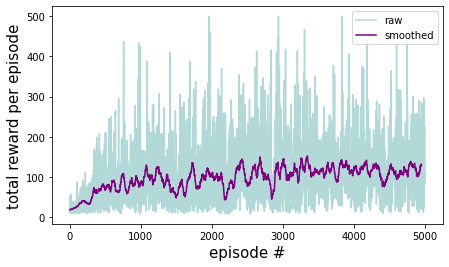

In [15]:
# visualize total reward per episode across training
plt.figure(figsize=(7,4))
plt.plot(qlearning_agent.reward_history, alpha=.3, color='teal', label='raw')
plt.plot(np.convolve(qlearning_agent.reward_history, np.ones((50,))/50, mode='valid'), color='purple', label='smoothed')
plt.xlabel('episode #', fontsize=15)
plt.ylabel('total reward per episode', fontsize=15)
plt.legend()
plt.show()

###Evaluating the agent

First, let's see what the average reward is across 100 trials when the agent is exploiting its learned policy (not using $\epsilon$-greedy exploration).

Now, let's visualize the agent acting according to its learned policy.

In [0]:
evaluate_policy(qlearning_agent, num_episodes=100)

Exploit reward average: 121.67


In [7]:
create_learned_policy_video(qlearning_agent, "video", num_episodes=1)

Woo, it learned something! This is definitely an improvement from random, but it's certainly not optimal (a reward of 500 is optimal). This agent could get better with more training but it would probably take a long time for it to reach optimal performance.

### What is the model learning?

We can tell that the model has learned something, but it would be nice to get some idea of what it's learned. In order to get a sense of this, we can visualize the learned Q-values across a set of states. For this example, we are going to plot Q-values as a function of pole velocity, while the cart position, cart velocity, and pole angle are all 0 (the pole is in the center, not moving, and upright). 

Intuitively, the agent should have learned to push the cart right if the pole velocity is to the right (>0), and to push the cart left if the pole velocity is to the left (<0). 


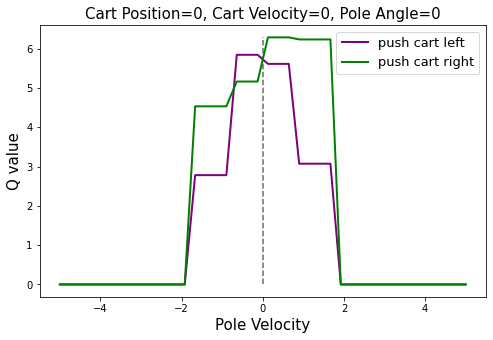

In [0]:
n_obs = 40
obs_array = np.zeros((n_obs, env.observation_space.shape[0]))
obs_array[:,0] = 0
obs_array[:,1] = 0
obs_array[:,2] = 0
obs_array[:,3] = np.linspace(-5, 5, n_obs)
# run model
q_values = np.zeros((n_obs, env.action_space.n))
for i, obs in enumerate(obs_array):
    obs_disctete = env_discrete.observation(obs)
    q_values[i] = [qlearning_agent.Q[obs_disctete, action] for action in qlearning_agent.actions]
# visualize results
plt.figure(figsize=(8,5))
plt.plot(obs_array[:,3], q_values[:,0], color='purple', label='push cart left', linewidth=2)
plt.plot(obs_array[:,3], q_values[:,1], color='green', label='push cart right', linewidth=2)
plt.vlines(0, q_values.min(), q_values.max(), linestyle='--', color='dimgray')
plt.xlabel('Pole Velocity', fontsize=15)
plt.ylabel('Q value', fontsize=15)
plt.title('Cart Position=0, Cart Velocity=0, Pole Angle=0', fontsize=15)
plt.legend(fontsize=13)
plt.show()

It does what we expect! The Q-values for a=right are larger than the Q-values for a=left when the pole velocity is greater than 0, and vice versa for when the pole velocity is less than 0. 

## Deep Q-Networks (DQN)


Now that we've implemented Q-learning, let's move on to implementing DQNs!

### Algorithm

Similar to Q-Learning, the method names for the DQN class give you the skeleton of the implementation, while the content is left for you to fill in. For DQNs you will need to write a few more functions than you needed for Q-Learning.

You need to fill in the content for six functions:

- `create_model` - filled in already
- `act()` 
- `remember()`
- `update_model()`
- `update_target()` - fillded in already
- `train()`




#### create_model()

For this implementation, we're going to use a two-layer densely connected network. This network will take in a state as input and output a Q-value estimate for each action within this state. Consequently, the input dim is the same as the `observation_space` shape (4 for the CartPole environment), and the output dim is the same as the `action_space` shape (2 for the CartPole environment). 

We've left the code for `create_model()` filled in because it is largely determined by learning TensorFlow syntax, which isn't our focus here. We will use ReLu activation function and the Adam optimizer.

We will use mean squared error loss, as specified by the DQN loss function.

    def create_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_shape[0], activation="relu"))
        model.add(Dense(16, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model




#### act() 

We will again use the $\epsilon$-greedy exploration policy. 

\begin{equation}
  a =
    \begin{cases}
      \text{random} & \text{with probability $\epsilon$}\\
      \arg\max_a Q(s,a)   & \text{otherwise}\\
    \end{cases}       
\end{equation}

To get the Q-values from your Q-network, you can run

    q_values = self.model.predict(state)

#### remember()

After each step, we need to store the $(s, a,r,s', \text{done})$ experience in the replay memory. In this implementation we will store memories in a `deque` with a specified maximum legnth (memory capacity).

In [0]:
replay_memory = deque(maxlen=5)
print(replay_memory)

for i in range(7):
    replay_memory.append(i)
    print(replay_memory)

# in your implementation you will append the experience
# [state, action, reward, next_state, done] instead of i

deque([], maxlen=5)
deque([0], maxlen=5)
deque([0, 1], maxlen=5)
deque([0, 1, 2], maxlen=5)
deque([0, 1, 2, 3], maxlen=5)
deque([0, 1, 2, 3, 4], maxlen=5)
deque([1, 2, 3, 4, 5], maxlen=5)
deque([2, 3, 4, 5, 6], maxlen=5)


#### update_model()

To update the model, you'll need to:

1. sample a batch of experiences $(s_j, a_j, r_j, s_j', \text{done}_j)$ from memory
2. calculate the target output (`done` indicates if $s$ is terminal)

\begin{equation}
  y_j =
    \begin{cases}
      r_j + \gamma \max_{a'} Q(s_j',a'; \theta^-) & \text{if $s$ is not terminal}\\
      r_j   & \text{if $s$ is terminal}\\
    \end{cases}       
\end{equation}

3. Perform gradient descent step according to

$$ L(\theta) = \left\langle \big( y_j - Q(s_j,a_j; \theta) \big)^2\right\rangle_{(s,a,r,s') \sim Uniform(Memory)}$$

For the third step, the TensorFlow code you will need is

    model.fit(batch_states, batch_target, epochs=1, verbose=0)


**NOTE**

The `batch_target` must be the same dimensions as the model output. This means you must have a target for every action for each input state in your batch of experiences $(s_j,a_j,r_j,s_j')$. For each action $a$ that is not in the experience batch, use the current output of the target model as the target value, $Q(s,a;\theta^-)$. Therefore, for each state $s_j$, 

\begin{equation}
  \text{target} =
    \begin{cases}
      y_j             & \text{if $a$ is in experience batch $(s_j, a_j, r_j, s_j')$}\\
      Q(s,a;\theta^-)   & \text{if $a$ is NOT in experience batch $(s_j, a_j, r_j, s_j')$}\\
    \end{cases}       
\end{equation}

**NOTE 2**

Here is a helpful line of code for reformating samples from memory, each of which will be a list `[state, action, reward, next_state, done]`, to a set of `np.array`s with dim (n_batch x __).

    batch_states, batch_actions, batch_rewards, batch_next_states, batch_done = map(np.asarray, zip(*memory_samples))


#### update_tartget()

This function is used to set the target network weights equal to the model network weights. This is only done periodically thoughout training, which reduces variance in the gradient across steps and stabilizes training. 

We've left the code for `update_target()` filled in because, again, it is largely just Tensorflow syntax. You'll have to use this function appropriately within the main training loop.

    def update_target(self):
        weights = self.model.get_weights()
        self.target_model.set_weights(weights)

#### train()

This function will run the main training loop. Here is the pseudocode for the DQN algorithm.

    initialize Q-network (create model)
    initialize target network (create model and set weights equal to Q-network)
    for n_episodes
        initialize state
        while not done
            select action according to policy
            execute action; observe reward and next_state
            add experience (state, action, reward, next_state, done) to memory
            sample batch of (state, action, reward, next_state, done) experiences from memory and update model
            every C steps, update target model



Same as for Q-learning, the Gym api calls you will need are:
- `observation = env.reset()`
- `observation, reward, done, info = env.step(action)`
- `action = env.action_space.sample()`

The Tensorflow api calls you will need are: 
- `model_output = model.predict(model_input)`
- `model.fit(model_input, model_target, epochs=1, verbose=0)`

#### Implementation

In [0]:
class DQN:
    def __init__(self, env, memory_cap=1000, gamma=0.9, epsilon=0.99, 
        epsilon_decay=0.995, epsilon_min=0.01, learning_rate=0.005, 
        batch_size=32, C=20):

        self.env = env
        self.memory = deque(maxlen=memory_cap)
        self.state_shape = env.observation_space.shape

        self.gamma = gamma
        self.epsilon = epsilon  
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.C = C

    def create_model(self):
        """We will use a two-layer perceptron. The input dim must equal the
        state space dim and the output dim must equal the action space dim, 
        but you can play around with the size of the hidden layers. For DQNs,
        we need mean squared error loss."""
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_shape[0], activation="relu"))
        model.add(Dense(16, activation="relu"))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def act(self, state, test=False):
        """Choose action based on your current model using epsilon-greedy
        exploration"""
        # update epsilon
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        epsilon = 0.01 if test else self.epsilon 
        # take random action with probability epsilon
        if np.random.random() < epsilon:
            return self.env.action_space.sample()
        # reshape state to feed into model (tensorflow thing, shape must be
        # (1, input_dim), not (input_dim,).)
        state = state.reshape((1, self.state_shape[0]))
        # get q_values from model
        q_values = self.model.predict(state)[0]
        # get action (argmax of Q-values)
        action = np.argmax(q_values)
        return action

    def remember(self, state, action, reward, new_state, done):
        """Append experience to memory"""
        self.memory.append([state, action, reward, new_state, done])

    def update_model(self):
        """This function updates the q-network model. You must 1) sample a
        batch of experiences from the replay memory 2) calculate the target for
        each expereince, 3) update the model by calling model.fit()"""
        # only update model once have sufficient number of experiences in memory
        if len(self.memory) < self.batch_size:
            return
        # sample a batch of experiences from memory
        memory_samples = random.sample(self.memory, self.batch_size)
        # reformat samples
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_done = map(np.asarray, zip(*memory_samples))
        # get target model predictions for current state
        batch_target = self.target_model.predict(batch_states)
        # get target model predictions for future state
        q_future = self.target_model.predict(batch_next_states).max(axis=1)
        # for actions within experience batch, replace target model predictions 
        # with the target value (r + gamma * max Q(s,a) if s not terminal, r is s terminal)
        batch_target[range(self.batch_size), batch_actions] = batch_rewards + (1 - batch_done) * q_future * self.gamma
        self.model.fit(batch_states, batch_target, epochs=1, verbose=0)

    def update_target(self):
        """"Sets target weights equal to model weights."""
        weights = self.model.get_weights()
        self.target_model.set_weights(weights)

    def train(self, num_episodes=50):
        """This function implements the main training loop."""
        # keep track of total reward per episode
        self.reward_history = []
        # initialize model and target model
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        # we need to keep track of steps now so we can update the model every 
        # C steps
        step = 0
        # interact with environment and update model
        for episode in range(num_episodes):
            total_reward = 0
            done = False
            state = self.env.reset()
            while not done:
                # select action according to policy
                action = self.act(state)
                # execute action
                next_state, reward, done, _ = self.env.step(action)
                # add experience to memory
                self.remember(state, action, reward, next_state, done)
                # update model (sample batch of experiences for update)
                self.update_model()
                
                total_reward += reward
                step += 1
                state = next_state
                if step % self.C:
                    self.update_target()
            
            # save total reward from epsisode and print training progress 
            self.reward_history.append(total_reward)    
            print("episode {}: {} reward".format(episode, total_reward))

### Training an agent

In [0]:
env = gym.make('CartPole-v1')   

seed = 2

env.seed(seed)
env.action_space.seed(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

dqn_agent = DQN(env, batch_size=32)
dqn_agent.train(num_episodes=35)

episode 0: 12.0 reward
episode 1: 14.0 reward
episode 2: 19.0 reward
episode 3: 19.0 reward
episode 4: 10.0 reward
episode 5: 10.0 reward
episode 6: 21.0 reward
episode 7: 16.0 reward
episode 8: 30.0 reward
episode 9: 11.0 reward
episode 10: 11.0 reward
episode 11: 50.0 reward
episode 12: 26.0 reward
episode 13: 23.0 reward
episode 14: 40.0 reward
episode 15: 113.0 reward
episode 16: 24.0 reward
episode 17: 43.0 reward
episode 18: 38.0 reward
episode 19: 8.0 reward
episode 20: 42.0 reward
episode 21: 64.0 reward
episode 22: 54.0 reward
episode 23: 70.0 reward
episode 24: 91.0 reward
episode 25: 30.0 reward
episode 26: 121.0 reward
episode 27: 213.0 reward
episode 28: 500.0 reward
episode 29: 500.0 reward
episode 30: 364.0 reward
episode 31: 401.0 reward
episode 32: 342.0 reward
episode 33: 309.0 reward
episode 34: 290.0 reward


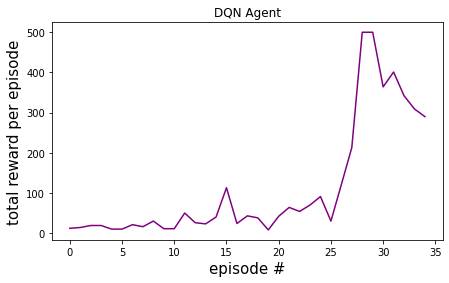

In [0]:
# visualize total reward per episode across training
plt.figure(figsize=(7,4))
plt.plot(dqn_agent.reward_history, alpha=1, color='purple', label='raw')
plt.xlabel('episode #', fontsize=15)
plt.ylabel('total reward per episode', fontsize=15)
plt.title('DQN Agent')
plt.show()

### Evaluating the agent

In [0]:
evaluate_policy(dqn_agent, num_episodes=1)

Exploit reward average: 227.0


In [0]:
create_learned_policy_video(dqn_agent, "video", num_episodes=1)

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


### What is the model learning?

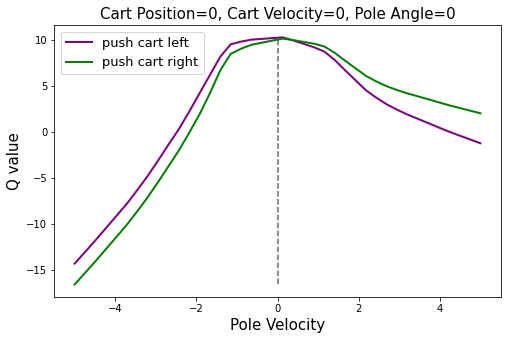

In [0]:
n_obs = 40
obs_array = np.zeros((n_obs, env.observation_space.shape[0]))
obs_array[:,0] = 0
obs_array[:,1] = 0
obs_array[:,2] = 0
obs_array[:,3] = np.linspace(-5, 5, n_obs)
# run model
q_values = dqn_agent.model.predict(obs_array)
# visualize results
plt.figure(figsize=(8,5))
plt.plot(obs_array[:,3], q_values[:,0], color='purple', label='push cart left', linewidth=2)
plt.plot(obs_array[:,3], q_values[:,1], color='green', label='push cart right', linewidth=2)
plt.vlines(0, q_values.min(), q_values.max(), linestyle='--', color='dimgray')
plt.xlabel('Pole Velocity', fontsize=15)
plt.ylabel('Q value', fontsize=15)
plt.title('Cart Position=0, Cart Velocity=0, Pole Angle=0', fontsize=15)
plt.legend(fontsize=13)
plt.show()

## Citations

A lot of the code in the Colab notebook was inpired by some really helpful posts from other people:

- Lillian Weng's [deep-reinforcement-learning-gym](https://github.com/lilianweng/deep-reinforcement-learning-gym) repo (adapted her Q-learning implementation)
- Anita Hu's [TF2-RL](https://github.com/anita-hu/TF2-RL) repo (adapted her DQN implementation)
- TF [tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) for training DQN with TF-Agents (adapted TF-Agents visualization functions for Gym)